In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import random
import numpy as np
import matplotlib.pyplot as plt

# from tsl.metrics.torch import MaskedMAE
# from tsl.engines import Predictor
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
# from einops import rearrange
from tqdm import tqdm

from dataset.utils import process_PVUS

seed = 42
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
pl.seed_everything(42)

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

c:\Users\mgphy\Anaconda3\envs\koopman\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")
Seed set to 42


# Load & process dataset

for more datasets:

https://github.com/dtortorella/dyngraphesn/tree/master

In [2]:
config = {
        'reservoir_size': 150,
        'input_scaling': 0.4,
        'reservoir_layers': 4,
        'leaking_rate': 0.5,
        'spectral_radius': 4.0,
        'density': 0.4,
        'reservoir_activation': 'self_norm',
        'alpha_decay': False
    }

In [3]:
train_dataloader, test_dataloader, val_dataloader = process_PVUS(config, device, ignore_file=False, verbose=True)

# Train the readout

In [4]:
class LinearRegression(pl.LightningModule):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self.forward(x)
        loss = nn.MSELoss()(output, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self.forward(x)
        loss = nn.MSELoss()(output, y)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        x, y = batch
        output = self.forward(x)
        loss = nn.MSELoss()(output, y)
        self.log('test_loss', loss)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.07)
        return optimizer


In [5]:
forecaster = LinearRegression(input_size=config['reservoir_size']*config['reservoir_layers'],
                              output_size=1).to(device)

In [8]:
logger = TensorBoardLogger(save_dir="logs", name="dynGESN", version=0)
# %load_ext tensorboard
# %tensorboard --logdir logs

checkpoint_callback = ModelCheckpoint(
    dirpath='logs',
    save_top_k=1,
    monitor='val_loss',
    mode='min',
)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.01, patience=3, verbose=False, mode="min")

trainer = pl.Trainer(
                    # fast_dev_run=True,
                    max_epochs=15,
                    logger=logger,
                    # profiler="simple",
                    # limit_train_batches=0.1, 
                    # limit_val_batches=0.1,
                    devices=1, 
                    accelerator="gpu" if torch.cuda.is_available() else "cpu",
                    limit_train_batches=50,  # end an epoch after 10 updates
                    limit_val_batches=50,  # end an epoch after 10 updates
                    callbacks=[checkpoint_callback, early_stop_callback])


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [9]:
trainer.fit(model=forecaster, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

c:\Users\mgphy\Anaconda3\envs\koopman\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:634: Checkpoint directory logs exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type   | Params
----------------------------------
0 | linear | Linear | 601   
----------------------------------
601       Trainable params
0         Non-trainable params
601       Total params
0.002     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\mgphy\Anaconda3\envs\koopman\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


c:\Users\mgphy\Anaconda3\envs\koopman\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 14: 100%|██████████| 50/50 [00:03<00:00, 15.71it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 50/50 [00:03<00:00, 15.68it/s, v_num=0]


In [10]:
torch.save(forecaster.state_dict(), "models/dynGESN_readout.pt")

In [19]:
# Specify the path to the saved model
model_path = "models/dynGESN_readout.pt"

# Create an instance of the LinearRegression model
loaded_model = LinearRegression(input_size=config['reservoir_size']*config['reservoir_layers'], output_size=1).to(device)

# Load the saved model state_dict
loaded_model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
loaded_model.eval()


LinearRegression(
  (encoder): DynGESNModel(
    (reservoir): DynGraphESN(
      (rnn_cells): ModuleList(
        (0-3): 4 x GESNLayer()
      )
    )
  )
  (linear): Linear(in_features=600, out_features=24, bias=True)
)

In [16]:
test_sample = next(iter(test_dataloader())).to(device)
output = loaded_model(test_sample.input.x, test_sample.input.edge_index, test_sample.input.edge_weight)

In [ ]:
outputs = []
targets = []

for test_sample in tqdm(test_dataloader()):
    test_sample = test_sample.to(device)
    output = loaded_model(test_sample.input.x, test_sample.input.edge_index, test_sample.input.edge_weight).squeeze()

    outputs.append(output)
    targets.append(test_sample.target.y)
    if len(outputs) >= 100:
        break

stacked_outputs = torch.stack(outputs, dim=0)
stacked_targets = torch.stack(targets, dim=0)

In [15]:
stacked_outputs.shape

torch.Size([100, 24, 1082])

In [21]:
stacked_targets.shape

torch.Size([100, 1, 24, 1082, 1])

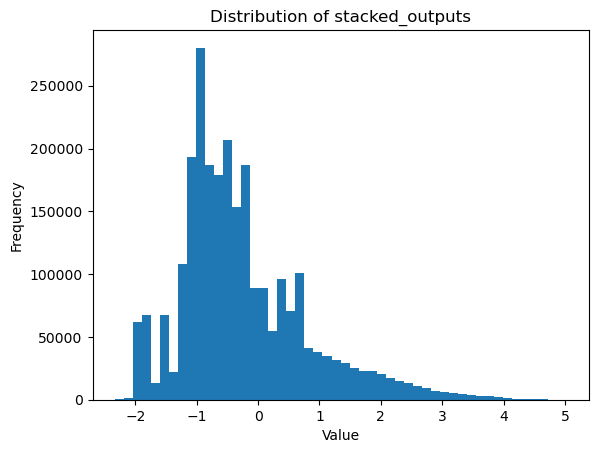

In [12]:
plt.hist(stacked_outputs.flatten().cpu().detach().numpy(), bins=50)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of stacked_outputs')
plt.show()


In [22]:
nonzero_indices = torch.nonzero(stacked_targets[:, 0, :, :, 0])
print(nonzero_indices)

tensor([[ 18,  23, 181],
        [ 18,  23, 193],
        [ 18,  23, 211],
        ...,
        [ 99,  12, 929],
        [ 99,  12, 931],
        [ 99,  13, 924]], device='cuda:0')


In [27]:
stacked_targets[99, 0,:,929,0]

tensor([20.3000, 19.9500, 19.9500, 19.3500, 18.8000, 18.2000, 17.0500, 15.6500,
        14.5500, 13.4000, 10.4500,  6.2500,  1.8500,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
       device='cuda:0')

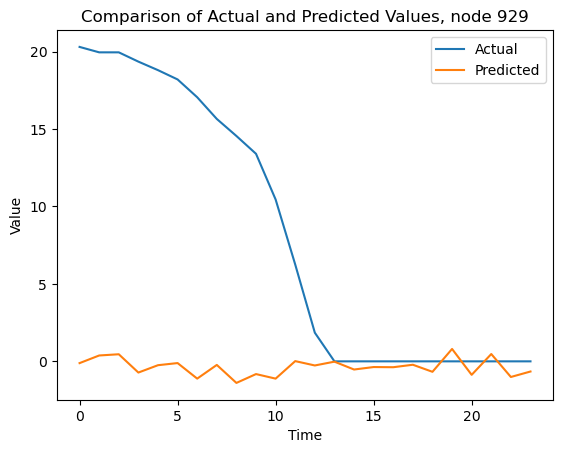

In [28]:
node_id = 929

plt.plot(stacked_targets[99,0,:,node_id,0].cpu().detach().numpy(), label='Actual')
plt.plot(stacked_outputs[99,:,node_id].cpu().detach().numpy(), label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Comparison of Actual and Predicted Values, node {node_id}')
plt.show()

# DMD

In [ ]:
from DMD.dmd import KANN

In [21]:
test_sample = next(iter(dm.test_dataloader())).to(device)

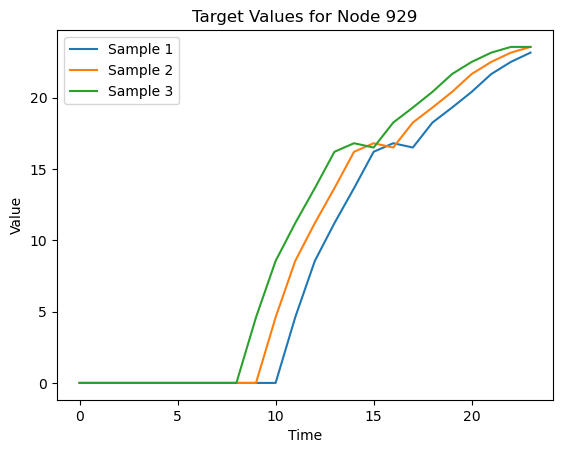

In [28]:
node_id = 929

for i, sample in enumerate(dm.test_dataloader()):
    plt.plot(sample.target.y[0, :, node_id, 0].cpu().detach().numpy(), label=f'Sample {i+1}')
    if i >= 2:
        break

plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Target Values for Node {node_id}')
plt.legend()
plt.show()


In [22]:
test_sample

StaticBatch(
  input=(x=[b=1, t=254, n=1082, f=1], edge_index=[2, e=124778], edge_weight=[e=124778]),
  target=(y=[b=1, t=24, n=1082, f=1]),
  has_mask=False,
  transform=[x, y]
)

In [24]:
model(test_sample.input.x, test_sample.input.edge_index, test_sample.input.edge_weight).shape

torch.Size([1, 1082, 600])

In [46]:
states = []

for i, sample in enumerate(dm.test_dataloader()):
    sample = sample.to(device)
    state_t = model(sample.input.x, sample.input.edge_index, sample.input.edge_weight).cpu().squeeze()
    states.append(state_t)
    if i > 100: # to make it faster
        break

states = torch.stack(states, dim=1)

In [47]:
states.shape

torch.Size([1082, 102, 600])

In [48]:
node_id = 929
norms = []
for i in range(10):
    norms.append(torch.linalg.vector_norm(states[i+node_id,:-1,:]-states[i+node_id,1:,:], dim=(1)))

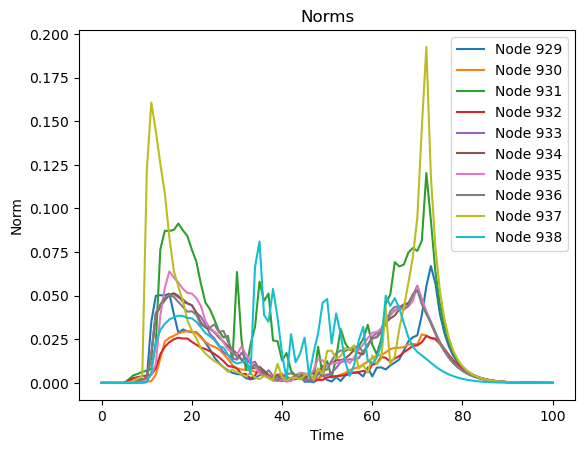

In [49]:
for i, norm in enumerate(norms):
    plt.plot(norm, label=f'Node {i+node_id}')

plt.xlabel('Time')
plt.ylabel('Norm')
plt.title('Norms')
plt.legend()
plt.show()

Global Koopman analysis at a node level

In [50]:
dim_red = 50
method = 'TruncatedSVD'

# compute local Koopman operator
kann_ = KANN(states.cpu(), k=dim_red, emb=method)

In [51]:
K = kann_.compute_KOP()

In [52]:
K.shape

(50, 50)

Project status of a node on most important eigenvalues and check what patterns is reflected more on which eigenspace